In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from datetime import datetime
import joblib

expense_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv");


heads = ['date', 'Head', 'comment', 'amount', 'Category']
additional_train_datas = [
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'diesel', '', 0.0, 'Fuel')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Ac fitting', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), '2 ACs', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Air Condition', '', 0.0, 'Appliances')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Printout', '', 0.0, 'Education')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'Coconut water', '', 0.0, 'Grocery')],
    [(datetime.now().strftime("%Y-%m-%dT%H:%M:%S"), 'paintor', '', 0.0, 'Maintenance')]
]
for additional_train_data in additional_train_datas:
    additional_train_data_df = pd.DataFrame.from_records(additional_train_data, columns=heads)
    expense_data = pd.concat([expense_data, additional_train_data_df], ignore_index=True)

    print(expense_data)
#expense_data.head


#X = expense_data.drop(columns=['date', 'amount', 'comment', 'Category']);
#y = expense_data['Category'];
#X.head



                     date           Head    comment  amount      Category
0     2019-06-18T18:47:30          T est        NaN     0.0         Other
1     2019-06-18T19:35:05     Vegetables        NaN   430.0       Grocery
2     2019-06-18T20:03:44  Bathla ladder        NaN  2199.0     Household
3     2019-06-18T20:05:52    Vegetables         NaN   405.0       Grocery
4     2019-06-18T20:06:09         Pizza         NaN   310.0  Food Outside
...                   ...            ...        ...     ...           ...
3899  2023-12-25T20:10:32          Lunch        NaN   600.0  Food Outside
3900  2023-12-26T21:00:05         Sweets        NaN  1628.0  Food Outside
3901  2023-12-26T21:12:57     Household   TDS meter   240.0     Household
3902  2023-12-26T21:22:41           Milk        NaN   100.0          Milk
3903  2023-12-28T00:50:34         diesel                0.0          Fuel

[3904 rows x 5 columns]
                     date           Head    comment  amount      Category
0     2019-06

In [2]:
expense_data['category_id'] = expense_data['Category'].factorize()[0]
category_id_expense = expense_data[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_expense.values)
id_to_category = dict(category_id_expense[['category_id', 'Category']].values)
expense_data

,date,Head,comment,amount,Category,category_id
0,2019-06-18T18:47:30,T est,NaN,0.0,Other,0
1,2019-06-18T19:35:05,Vegetables,NaN,430.0,Grocery,1
2,2019-06-18T20:03:44,Bathla ladder,NaN,2199.0,Household,2
3,2019-06-18T20:05:52,Vegetables,NaN,405.0,Grocery,1
4,2019-06-18T20:06:09,Pizza,NaN,310.0,Food Outside,3
...,...,...,...,...,...,...
3905,2023-12-28T00:50:34,2 ACs,,0.0,Appliances,21
3906,2023-12-28T00:50:34,Air Condition,,0.0,Appliances,21
3907,2023-12-28T00:50:34,Printout,,0.0,Education,7
3908,2023-12-28T00:50:34,Coconut water,,0.0,Grocery,1


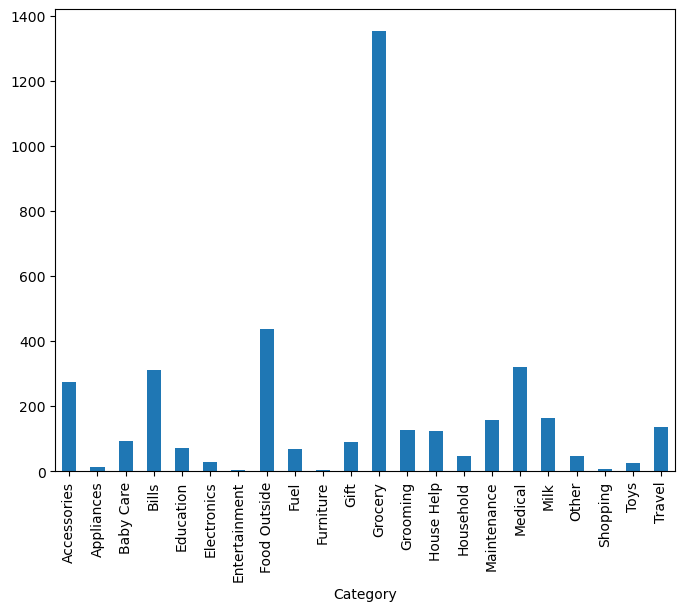

In [3]:
fig = plt.figure(figsize=(8,6))
expense_data.groupby('Category').Head.count().plot.bar(ylim=0)
plt.show()

In [4]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(expense_data.Head).toarray()
labels = expense_data.category_id
features.shape

(3910, 186)

In [5]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Accessories':
  . Most correlated unigrams:
. accessories
. shopping
  . Most correlated bigrams:
. baby dress
. cuckoo dress
# 'Appliances':
  . Most correlated unigrams:
. machine
. washing
  . Most correlated bigrams:
. mobile recharge
. washing machine
# 'Baby Care':
  . Most correlated unigrams:
. diapers
. baby
  . Most correlated bigrams:
. baby wipes
. baby care
# 'Bills':
  . Most correlated unigrams:
. electricity
. mobile
  . Most correlated bigrams:
. netflix recharge
. mobile recharge
# 'Education':
  . Most correlated unigrams:
. book
. xerox
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Electronics':
  . Most correlated unigrams:
. watch
. electronics
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Entertainment':
  . Most correlated unigrams:
. vegetable
. groceries
  . Most correlated bigrams:
. doctor consultation
. mobile recharge
# 'Food Outside':
  . Most correlated unigrams:
. water
. snacks
  . Most correlated 

In [6]:
#expense_data['HeadAndCommentAndAmount'] = expense_data['Head'].astype(str) + '-' + expense_data['Comment'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(
    expense_data['Head'], expense_data['Category'], test_size=.001, random_state = 0
)
print(X_train.size)
print(y_train.size)
print(X_test.size)
print(y_test.size)
print(X_test)
print(y_test)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf)
clf = LogisticRegression(fit_intercept=False).fit(X_train_tfidf, y_train)
#clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(X_train_tfidf, y_train)
#clf = MultinomialNB().fit(X_train_tfidf, y_train)
#clf = LinearSVC().fit(X_train_tfidf, y_train)

3906
3906
4
4
3538    Mobile Recharge 
192              Tatasky
2065      Broadband bill
2490            Crackers
Name: Head, dtype: object
3538    Bills
192     Bills
2065    Bills
2490    Other
Name: Category, dtype: object
  (0, 615)	1.0
  (1, 295)	1.0
  (2, 416)	1.0
  (3, 243)	1.0
  (4, 119)	1.0
  (5, 176)	1.0
  (6, 746)	1.0
  (7, 78)	0.7715073240872897
  (7, 14)	0.6362204404761527
  (8, 114)	1.0
  (9, 416)	1.0
  (10, 644)	1.0
  (11, 26)	1.0
  (12, 586)	1.0
  (13, 682)	0.7831465021132408
  (13, 67)	0.6218372425545095
  (14, 131)	1.0
  (15, 202)	0.6897379550829388
  (15, 148)	0.724059081372512
  (16, 419)	1.0
  (17, 419)	1.0
  (18, 679)	0.719660689689938
  (18, 205)	0.6943259261434809
  (19, 255)	1.0
  (20, 230)	0.7762453401156556
  :	:
  (3886, 502)	1.0
  (3887, 280)	1.0
  (3888, 720)	0.8289741714232067
  (3888, 2)	0.5592868880218881
  (3889, 502)	1.0
  (3890, 101)	0.7834909968565996
  (3890, 30)	0.621403136333131
  (3891, 745)	1.0
  (3892, 273)	1.0
  (3893, 765)	0.7905142385495106

In [7]:
results = clf.predict(count_vect.transform(["Coconut water"]))
#prob_per_class_dictionary = dict(zip(model.classes_, results))

print(results)

['Food Outside']


/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aloksingh/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: Future

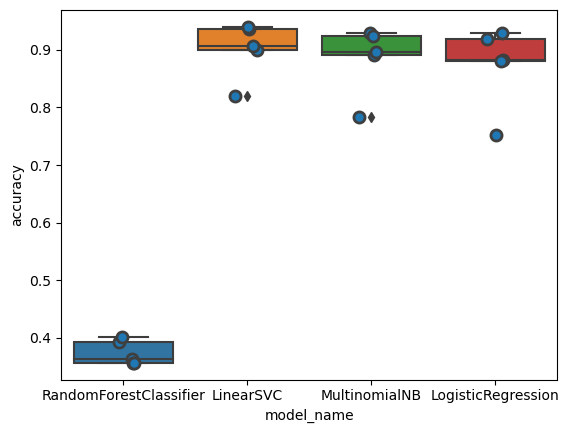

In [8]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(fit_intercept=False),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.900256
LogisticRegression        0.872379
MultinomialNB             0.884910
RandomForestClassifier    0.374169
Name: accuracy, dtype: float64

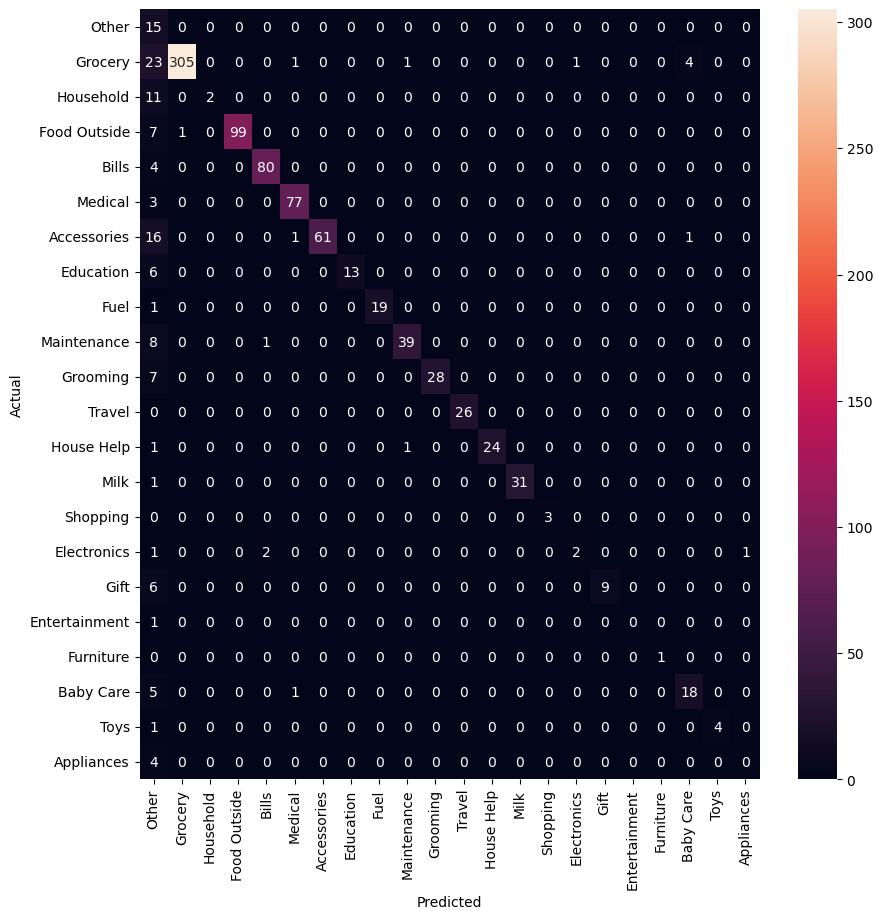

In [10]:
model = LogisticRegression(fit_intercept=False)
#model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, expense_data.index, test_size=0.25, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_expense.Category.values, yticklabels=category_id_expense.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
#pd.options.display.float_format = '{:,.2f}'.format
#test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv").drop(columns=['Timestamp', 'Amount', 'Month', 'Year', 'Category', 'Comment']);
test_data = pd.read_csv("~/Downloads/Expense Sheet - Categorized.csv")
test_data.head()
print()

#expense_data['category_id'] = expense_data['Category'].factorize()[0]
#clf.predict(count_vect.transform(list(test_data)))
#test_data['predicted'] = clf.predict(test_data['Head'].factorize()[0])

#test_data.groupby(['predicted']).sum()
#test_data.groupby(['predicted']).sum().plot.pie( subplots=True,figsize=(5, 5))

In [12]:
joblib.dump(clf, '/Users/aloksingh/git/expense-catecorization/expense-categorization-mdl.joblib');

In [13]:
joblib.dump(count_vect, '/Users/aloksingh/git/expense-catecorization/expense-categorization-vct.joblib');

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document']
vocabulary = ['this', 'document', 'first', 'is', 'second', 'the',
              'and', 'one']
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
                 ('tfid', TfidfTransformer())]).fit(corpus)
pipe['count'].transform(corpus).toarray()


array([[1, 1, 1, 1, 0, 1, 0, 0],
       [1, 2, 0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0]])

In [15]:
pipe['tfid'].idf_
pipe.transform(corpus).shape

(4, 8)